In [6]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load('psth_data.npz')
psth_odr  = data['psth_odr']    # (2131, 8, 100) in Hz
psth_odrd = data['psth_odrd']   # (1319, 4, 100) in Hz
t         = data['bin_centers']  # time axis in ms



ValueError: x and y must have same first dimension, but have shapes (100,) and (8, 100)

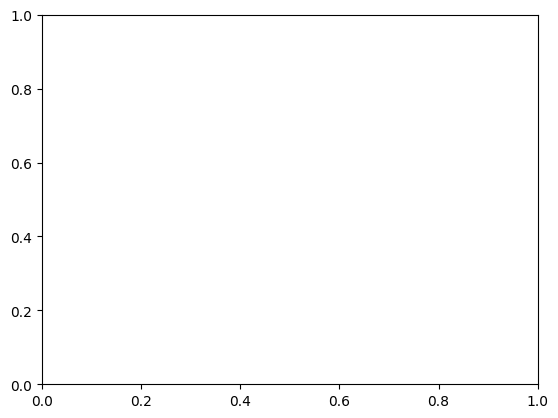

In [7]:
plt.plot(t, psth_odr.mean(axis=0), label='odr')
plt.plot(t, psth_odrd.mean(axis=0), label='odrd')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Average PSTH for ODR and ODRD Tasks')
plt.legend()


In [ ]:
psth_odr.shape[0]

2131

Text(0.5, 0, 'Time (ms)')

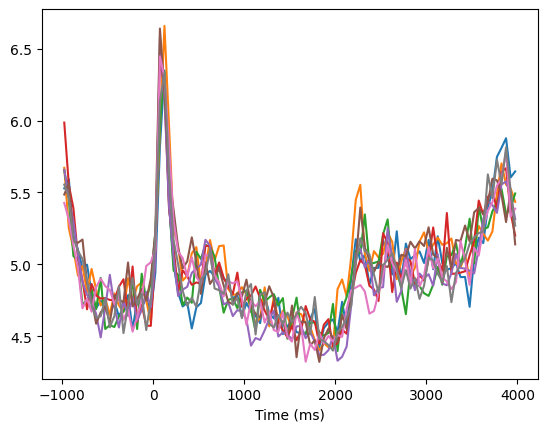

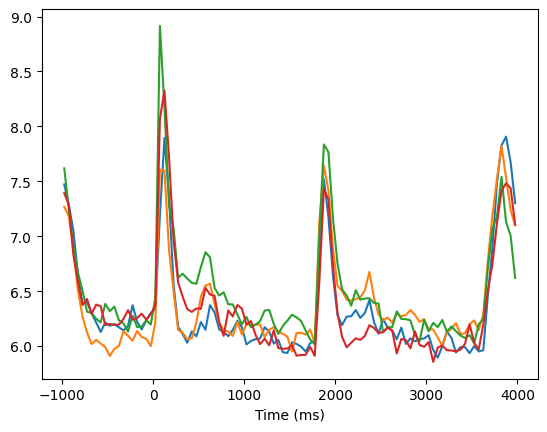

In [ ]:
[plt.plot(t,np.nanmean(psth_odr, axis=0)[c]) for c in range(psth_odr.shape[1])]
plt.xlabel('Time (ms)')

plt.figure()

[plt.plot(t,np.nanmean(psth_odrd, axis=0)[c]) for c in range(psth_odrd.shape[1])]
plt.xlabel('Time (ms)')

In [9]:
"""
Cross-temporal SVM decoding on pseudo-populations (ODR task).

For each pair (t_train, t_test), an SVM is trained on population vectors at
t_train and tested at t_test using stratified K-fold cross-validation.

Pseudo-population: since neurons come from different sessions, single-trial
responses are randomly paired across neurons within each condition.
"""

import scipy.io as sio
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import time

DATA_DIR = "./data_raw/"

# ── Parameters ────────────────────────────────────────────────────────────────
BIN_MS       = 50          # bin width (ms)
T_START      = -1000       # ms relative to cue onset
T_END        = 4000        # ms
MIN_TRIALS   = 5           # minimum trials per condition to include a neuron
N_PSEUDO     = 10          # pseudo-trials per condition (sampled with replacement)
N_CV_FOLDS   = 5           # stratified K-fold
N_PERM       = 10          # number of pseudo-population resamplings
C_REG        = 1.0         # SVM regularisation
RANDOM_SEED  = 42

bin_edges   = np.arange(T_START, T_END + BIN_MS, BIN_MS)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
n_bins      = len(bin_centers)

np.random.seed(RANDOM_SEED)

# ═══════════════════════════════════════════════════════════════════════════════
# 1. EXTRACT SINGLE-TRIAL FIRING RATES
# ═══════════════════════════════════════════════════════════════════════════════
print("Loading ODR data ...")
mat = sio.loadmat(
    os.path.join(DATA_DIR, "odr_data_both_sig_is_best_20240109.mat"),
    squeeze_me=False,
)
odr = mat["odr_data_new"]
n_neurons_raw, n_cond = odr.shape
print(f"  {n_neurons_raw} neurons × {n_cond} conditions")

print("Extracting single-trial firing rates ...")
# Store as list of lists: single_trial[neuron][condition] = array (n_trials, n_bins)
single_trial = []
trial_counts = np.zeros((n_neurons_raw, n_cond), dtype=int)


Loading ODR data ...
  2131 neurons × 8 conditions
Extracting single-trial firing rates ...


In [11]:

for i in range(n_neurons_raw):
    neuron_data = []
    for c in range(n_cond):
        cell = odr[i, c]
        if cell is None or (isinstance(cell, np.ndarray) and cell.size == 0):
            neuron_data.append(np.empty((0, n_bins)))
            continue

        n_trials = max(cell.shape)
        ts_arr  = cell["TS"].flatten()
        cue_arr = cell["Cue_onT"].flatten()

        trial_rates = []
        for t in range(n_trials):
            ts_raw  = ts_arr[t]
            cue_raw = cue_arr[t]
            if hasattr(ts_raw, "flatten"):
                ts_raw = ts_raw.flatten()
            if hasattr(cue_raw, "flatten"):
                cue_raw = cue_raw.flatten()
                if cue_raw.size > 0:
                    cue_raw = cue_raw[0]

            if hasattr(ts_raw, "size") and ts_raw.size > 0:
                aligned_ms = (ts_raw - cue_raw) * 1000.0
                hist, _ = np.histogram(aligned_ms, bins=bin_edges)
            else:
                hist = np.zeros(n_bins)

            trial_rates.append(hist / (BIN_MS / 1000.0))  # Hz

        arr = np.array(trial_rates)  # (n_trials, n_bins)
        neuron_data.append(arr)
        trial_counts[i, c] = arr.shape[0]

    single_trial.append(neuron_data)

    if i % 500 == 0:
        print(f"  neuron {i}/{n_neurons_raw}")

# ═══════════════════════════════════════════════════════════════════════════════
# 2. SELECT NEURONS WITH ENOUGH TRIALS
# ═══════════════════════════════════════════════════════════════════════════════
min_per_neuron = trial_counts.min(axis=1)  # min across conditions
valid_neurons  = np.where(min_per_neuron >= MIN_TRIALS)[0]
n_valid = len(valid_neurons)

print(f"\n  Valid neurons (>= {MIN_TRIALS} trials/cond): {n_valid} / {n_neurons_raw}")
print(f"  Pseudo-trials per condition: {N_PSEUDO} (sampled with replacement)")
print(f"  Total samples: {N_PSEUDO * n_cond} ({n_cond} cond × {N_PSEUDO} trials)")


  neuron 0/2131
  neuron 500/2131
  neuron 1000/2131
  neuron 1500/2131
  neuron 2000/2131

  Valid neurons (>= 5 trials/cond): 1985 / 2131
  Pseudo-trials per condition: 10 (sampled with replacement)
  Total samples: 80 (8 cond × 10 trials)


Text(0.5, 1.0, 'Distribution of Minimum Trials per Neuron')

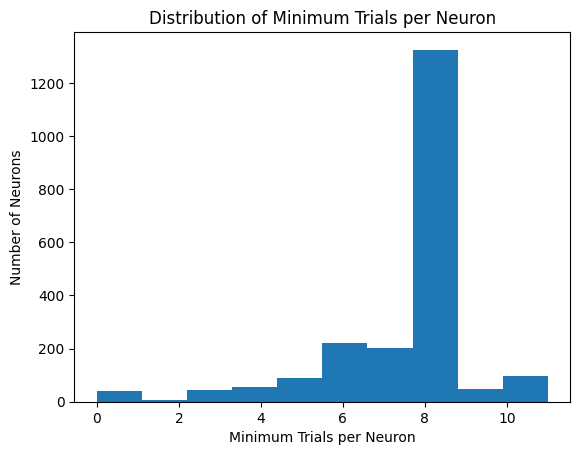

In [13]:
plt.hist(min_per_neuron)
plt.xlabel("Minimum Trials per Neuron")
plt.ylabel("Number of Neurons")
plt.title("Distribution of Minimum Trials per Neuron")


(array([ 119.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    6.,
        2006.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

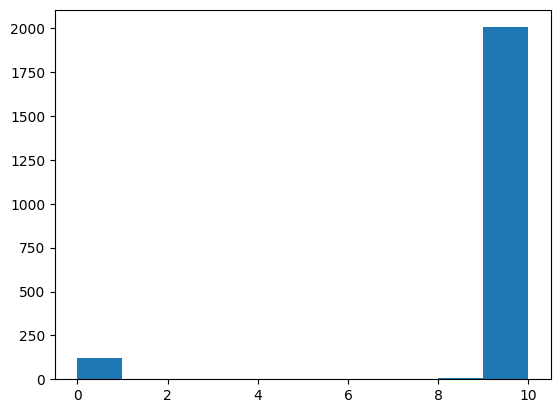

In [ ]:
plt.hist([len(odr[i][0][0][4]) if len(odr[i][0][0]) > 4 else 0 for i in range(n_neurons_raw)])

In [ ]:
data = mat["odr_data_new"][0][0]

In [ ]:
      dtype=[('Cue_onT', 'O'), ('Fix_offT', 'O'), ('Target_onT', 'O'), ('trialnum', 'O'), ('TS', 'O'), ('IsTarget', 'O'), ('fixrate', 'O'), ('cuerate', 'O'), ('cuedelay', 'O'), ('sacrate', 'O')])

10

In [ ]:
len(data[0][0][4])

1

In [ ]:
print("\nLoading ODRd data ...")
mat2 = sio.loadmat(
    os.path.join(DATA_DIR, "odrd_data_sig_on_best_20231018.mat"),
    squeeze_me=False,
)


Loading ODRd data ...


In [ ]:
mat2["odrd_data_new"][2][3][0]

array([(array([[1.4106]]), array([[4.9106]]), array([[3.19465]]), array([[4.9788]]), array([[10]], dtype=uint8), array([[19]], dtype=uint8), array([[0.509625, 1.861475, 2.553925, 3.71035 , 5.573425, 5.706575,
               5.7421  , 6.11075 , 7.029375, 7.218175, 7.732525, 8.282475,
               8.458025, 8.938375, 9.19805 , 9.25205 , 9.409975, 9.55735 ,
               9.61425 , 9.684625]]), array([[1]], dtype=uint8), array([[2]], dtype=uint8), array([[0.8]]), array([[0]], dtype=uint8), array([[0.8]]), array([[0]], dtype=uint8))                               ,
       (array([[1.823525]]), array([[5.323525]]), array([[3.607775]]), array([[5.3918]]), array([[19]], dtype=uint8), array([[16]], dtype=uint8), array([[0.26195 , 0.599075, 1.019   , 2.6937  , 4.6203  , 4.633625,
               5.627425, 5.8469  , 6.41425 , 9.05355 , 9.417425, 9.507075]]), array([[1]], dtype=uint8), array([[0]], dtype=uint8), array([[0.8]]), array([[0]], dtype=uint8), array([[1.6]]), array([[2]], dtype=uint8))

In [ ]:
import numpy as np                                                                                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                                                                                            
data = np.load('psth_by_monkey_age.npz', allow_pickle=True)                                                                                                                                                                                                                                                                 
                                                                                        
# Population-averaged PSTHs: (8 monkeys, 3 age groups, 8 conditions, 70 time bins)                                                                                                                                                                                                                                          
psth = data['psth']                                                                                                                                                                                                                                                                                                         
monkey_names = data['monkey_names']   # ['OLI', 'PIC', 'QUA', 'ROS', 'SON', 'TRI', 'UNI', 'VIK']
age_edges = data['age_edges']         # (8, 4) age tercile edges in months
t = data['bin_centers']               # (70,) time axis in ms

# Per-neuron PSTHs: (1180 neurons, 8 conditions, 70 time bins)
psth_all = data['psth_all']
id_col = data['id_col']               # (1180,) monkey ID per neuron
abs_age_months = data['abs_age_months']  # (1180,) absolute age in months
age_group = data['age_group']          # (1180,) age tercile (0, 1, 2)
neuron_counts = data['neuron_counts']  # (8, 3) neurons per monkey × age group

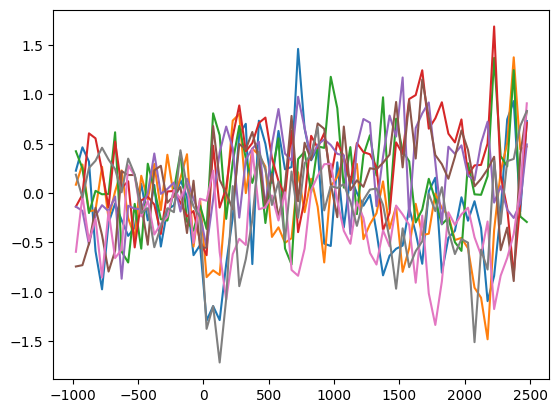

In [ ]:
plt.plot(t,np.mean([(psth[m][0] - np.mean(psth[m][0])) - (psth[m][2] - np.mean(psth[m][2])) for m in range(psth.shape[0])],0).T)

In [ ]:
                                 
import numpy as np                                                                                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                                                                                            
data = np.load('tuning_curves.npz', allow_pickle=True)                                                                                                                                                                                                                                                                      
                                                                                                                                                                                                                                                                                                                            
# Grouped: 8 monkeys × 3 age groups × 8 conditions × 4 epochs                                                                                                                                                                                                                                                               
tuning = data['tuning']                    # (8, 3, 8, 4)
monkey_names = data['monkey_names']        # ['OLI','PIC','QUA','ROS','SON','TRI','UNI','VIK']
age_edges = data['age_edges']              # (8, 4) tercile edges in months
neuron_counts = data['neuron_counts']      # (8, 3)
epoch_names = data['epoch_names']          # ['cue','early_delay','late_delay','response']
epoch_windows = data['epoch_windows']      # (4, 2) start/end in ms

# Per-neuron: 1180 neurons × 8 conditions × 4 epochs
tuning_all = data['tuning_all']            # (1180, 8, 4)
id_col = data['id_col']                    # (1180,) monkey ID
abs_age_months = data['abs_age_months']    # (1180,) age in months
age_group = data['age_group']              # (1180,) tercile 0/1/2


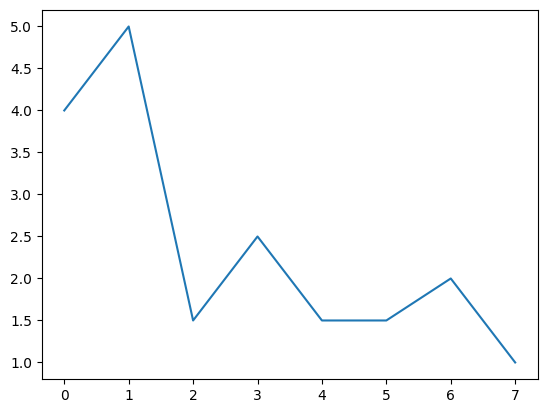

In [ ]:
plt.plot(tuning_all[100,:,0])

In [ ]:
import numpy as np                                                                                                                                                                                                                                                                                                          
from sklearn.decomposition import PCA                                 
                                                                                                                                                                                                                                                                                                                            
data = np.load('tuning_curves.npz', allow_pickle=True)                                   
                                                                                                                                                                                                                                                                                                                            
tuning_all     = data['tuning_all']       # (1180, 8, 4)                                                                                                                                                                                                                                                                    
id_col         = data['id_col']
abs_age_months = data['abs_age_months']
age_group      = data['age_group']
monkey_names   = data['monkey_names']
age_edges      = data['age_edges']

# Cue + delay (average early+late) → (1180, 8, 2)
cue_rate   = tuning_all[:, :, 0]
delay_rate = np.nanmean(tuning_all[:, :, 1:3], axis=2)
tuning_cue_delay = np.stack([cue_rate, delay_rate], axis=2)    # (1180, 8, 2)

N_PCS = 15

# tables[monkey][age_group] = array of shape (15, 16)
tables = {}
for mi, mid in enumerate(monkey_names):
    tables[mid] = {}
    for g in range(3):
        mask = (id_col == mid) & (age_group == g)
        X = tuning_cue_delay[mask].reshape(-1, 16)  # (n_neurons, 16)

        # PCA across neurons (features = 16 condition×epoch combos)
        n_neurons = X.shape[0]
        n_pcs = 15
        pca = PCA(n_components=n_pcs)
        X_pca = pca.fit_transform(X.T)              # (n_neurons, n_pcs)

        # Project: components are (n_pcs, 16), each row is a PC's loadings
        # tables entry = components reshaped as (n_pcs, 16)
        tables[mid][g] = X_pca.T           # (n_pcs, 16)

        e0, e1 = age_edges[mi, g], age_edges[mi, g + 1]
        ev = pca.explained_variance_ratio_.sum() * 100
        print(f"{mid} age {g} ({e0:.0f}-{e1:.0f} mo): "
            f"{n_neurons} neurons → {n_pcs} PCs  ({ev:.1f}% var explained)")


OLI age 0 (47-59 mo): 23 neurons → 15 PCs  (100.0% var explained)
OLI age 1 (59-64 mo): 30 neurons → 15 PCs  (100.0% var explained)
OLI age 2 (64-69 mo): 33 neurons → 15 PCs  (100.0% var explained)
PIC age 0 (47-59 mo): 24 neurons → 15 PCs  (100.0% var explained)
PIC age 1 (59-63 mo): 22 neurons → 15 PCs  (100.0% var explained)
PIC age 2 (63-63 mo): 31 neurons → 15 PCs  (100.0% var explained)
QUA age 0 (48-51 mo): 19 neurons → 15 PCs  (100.0% var explained)
QUA age 1 (51-54 mo): 18 neurons → 15 PCs  (100.0% var explained)
QUA age 2 (54-54 mo): 19 neurons → 15 PCs  (100.0% var explained)
ROS age 0 (46-52 mo): 17 neurons → 15 PCs  (100.0% var explained)
ROS age 1 (52-63 mo): 28 neurons → 15 PCs  (100.0% var explained)
ROS age 2 (63-68 mo): 24 neurons → 15 PCs  (100.0% var explained)
SON age 0 (42-52 mo): 110 neurons → 15 PCs  (100.0% var explained)
SON age 1 (52-57 mo): 105 neurons → 15 PCs  (100.0% var explained)
SON age 2 (57-63 mo): 115 neurons → 15 PCs  (100.0% var explained)
TRI age

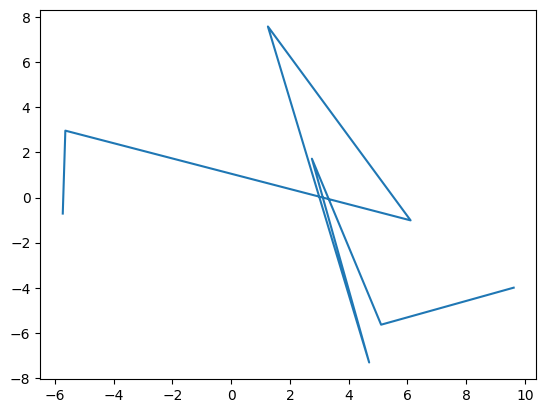

In [ ]:
plt.plot(tables["OLI"][0][0][:8],tables["OLI"][0][1][:8],)

In [ ]:
import numpy as np                                                                                                                                                                                                                                                                                                          
from sklearn.decomposition import PCA                                 
from scipy.spatial import procrustes                                                                                                                                                                                                                                                                                        
from itertools import product                                                            
                                                                                                                                                                                                                                                                                                                            
data = np.load('tuning_curves.npz', allow_pickle=True)                                                                                                                                                                                                                                                                      
tuning_all   = data['tuning_all']       # (1180, 8, 4)
id_col       = data['id_col']
age_group    = data['age_group']
monkey_names = list(data['monkey_names'])
age_edges    = data['age_edges']

# ── Build tuning matrices: cue + delay → (1180, 8, 2) ────────────────────────
cue_rate   = tuning_all[:, :, 0]
delay_rate = np.nanmean(tuning_all[:, :, 1:3], axis=2)
tuning_cd  = np.stack([cue_rate, delay_rate], axis=2)

# ── PCA: reduce neurons → 15 PCs per (monkey, age) ───────────────────────────
N_PCS = 15
labels = []       # list of (monkey, age_group) strings
matrices = []     # list of (15, 16) arrays

for mi, mid in enumerate(monkey_names):
    for g in range(3):
        mask = (id_col == mid) & (age_group == g)
        X = tuning_cd[mask].reshape(-1, 16)          # (n_neurons, 16)
        n_pcs = min(N_PCS, X.shape[0], 15)
        pca = PCA(n_components=n_pcs)
        X_pca = pca.fit_transform(X.T).T             # (n_pcs, 16)
        # Pad if fewer than N_PCS
        if n_pcs < N_PCS:
            X_pca = np.vstack([X_pca, np.zeros((N_PCS - n_pcs, 16))])
        matrices.append(X_pca)
        e0, e1 = age_edges[mi, g], age_edges[mi, g + 1]
        labels.append(f"{mid}_G{g}({e0:.0f}-{e1:.0f})")

n = len(labels)

# ── Procrustes distance matrix ────────────────────────────────────────────────
dist = np.zeros((n, n))
for i, j in product(range(n), repeat=2):
    if i < j:
        _, _, d = procrustes(matrices[i].T, matrices[j].T)  # inputs: (16, 15)
        dist[i, j] = dist[j, i] = d

# ── Print ─────────────────────────────────────────────────────────────────────
print("Procrustes distance matrix:")
print(f"{'':>25s}", "  ".join(f"{l:>8s}" for l in labels))
for i, l in enumerate(labels):
    print(f"{l:>25s}", "  ".join(f"{dist[i,j]:8.4f}" for j in range(n)))

Procrustes distance matrix:
                          OLI_G0(47-59)  OLI_G1(59-64)  OLI_G2(64-69)  PIC_G0(47-59)  PIC_G1(59-63)  PIC_G2(63-63)  QUA_G0(48-51)  QUA_G1(51-54)  QUA_G2(54-54)  ROS_G0(46-52)  ROS_G1(52-63)  ROS_G2(63-68)  SON_G0(42-52)  SON_G1(52-57)  SON_G2(57-63)  TRI_G0(40-56)  TRI_G1(56-61)  TRI_G2(61-62)  UNI_G0(39-49)  UNI_G1(49-61)  UNI_G2(61-61)  VIK_G0(45-51)  VIK_G1(51-63)  VIK_G2(63-68)
            OLI_G0(47-59)   0.0000    0.6522    0.5649    0.6781    0.6857    0.5335    0.5867    0.6401    0.6753    0.6595    0.6578    0.6412    0.5731    0.5746    0.4528    0.4832    0.6123    0.5462    0.4336    0.5883    0.5306    0.6781    0.4732    0.7212
            OLI_G1(59-64)   0.6522    0.0000    0.4722    0.5688    0.5665    0.4009    0.6080    0.6376    0.6139    0.6592    0.7027    0.6866    0.5024    0.5398    0.5326    0.5343    0.6820    0.5750    0.5884    0.7158    0.6463    0.6305    0.5267    0.6590
            OLI_G2(64-69)   0.5649    0.4722    0.0000   

In [ ]:
import numpy as np                                                                                                                                                                                                                                                                                                          
from sklearn.decomposition import PCA                                 
from scipy.spatial import procrustes                                                                                                                                                                                                                                                                                        
from itertools import product                                                                                                                                                                                                                                                                                               
                                                                                                                                                                                                                                                                                                                            
data = np.load('tuning_curves.npz', allow_pickle=True)                                                                                                                                                                                                                                                                      
tuning_all   = data['tuning_all']
id_col       = data['id_col']
age_group    = data['age_group']
monkey_names = list(data['monkey_names'])
age_edges    = data['age_edges']

# ── Tuning: cue + delay → (1180, 8, 2) ───────────────────────────────────────
cue_rate   = tuning_all[:, :, 0]
delay_rate = np.nanmean(tuning_all[:, :, 1:3], axis=2)
tuning_cd  = np.stack([cue_rate, delay_rate], axis=2)

# ── PCA per (monkey, age) → 15 PCs ───────────────────────────────────────────
N_PCS = 15
labels, matrices, mean_ages = [], [], []

for g in range(3):
    for mi, mid in enumerate(monkey_names):
        mask = (id_col == mid) & (age_group == g)
        X = tuning_cd[mask].reshape(-1, 16)          # (n_neurons, 16)

        # Drop neurons with any NaN or zero std
        good = np.all(np.isfinite(X), axis=1) & (np.std(X, axis=1) > 0)
        X = X[good]

        # Z-score each neuron across the 16 conditions
        X = (X - X.mean(axis=1)[:, None]) / X.std(axis=1)[:, None]

        n_pcs = min(N_PCS, X.shape[0], 16)
        pca = PCA(n_components=n_pcs)
        X_pca = pca.fit_transform(X.T).T
        if n_pcs < N_PCS:
            X_pca = np.vstack([X_pca, np.zeros((N_PCS - n_pcs, 16))])
        matrices.append(X_pca)
        e0, e1 = age_edges[mi, g], age_edges[mi, g + 1]
        mean_ages.append((e0 + e1) / 2)
        labels.append(f"{mid}_G{g}({e0:.0f}-{e1:.0f})")

# Sort by mean age
order = np.argsort(mean_ages)
labels   = [labels[i] for i in order]
matrices = [matrices[i] for i in order]

# ── Procrustes distance matrix ────────────────────────────────────────────────
n = len(labels)
dist = np.zeros((n, n))
for i, j in product(range(n), repeat=2):
    if i < j:
        _, _, d = procrustes(matrices[i].T, matrices[j].T)
        dist[i, j] = dist[j, i] = d

# ── Print ─────────────────────────────────────────────────────────────────────
print("Procrustes distance matrix (ordered by age):\n")
print(f"{'':>25s}", "  ".join(f"{l:>8s}" for l in labels))
for i, l in enumerate(labels):
    print(f"{l:>25s}", "  ".join(f"{dist[i,j]:8.4f}" for j in range(n)))


Procrustes distance matrix (ordered by age):

                          UNI_G0(39-49)  SON_G0(42-52)  TRI_G0(40-56)  VIK_G0(45-51)  ROS_G0(46-52)  QUA_G0(48-51)  QUA_G1(51-54)  PIC_G0(47-59)  OLI_G0(47-59)  QUA_G2(54-54)  SON_G1(52-57)  UNI_G1(49-61)  VIK_G1(51-63)  ROS_G1(52-63)  TRI_G1(56-61)  SON_G2(57-63)  PIC_G1(59-63)  UNI_G2(61-61)  TRI_G2(61-62)  OLI_G1(59-64)  PIC_G2(63-63)  VIK_G2(63-68)  ROS_G2(63-68)  OLI_G2(64-69)
            UNI_G0(39-49)   0.0000    0.1849    0.1723    0.2280    0.3760    0.2324    0.3082    0.2784    0.2110    0.2876    0.2051    0.1744    0.2110    0.2506    0.2541    0.1450    0.4025    0.2139    0.2603    0.2869    0.2728    0.2241    0.3577    0.1883
            SON_G0(42-52)   0.1849    0.0000    0.0713    0.1178    0.2518    0.2200    0.2362    0.1782    0.2007    0.2834    0.0659    0.2017    0.0973    0.1611    0.1387    0.0694    0.2299    0.1022    0.1133    0.1644    0.2462    0.1222    0.2150    0.1378
            TRI_G0(40-56)   0.1723    0

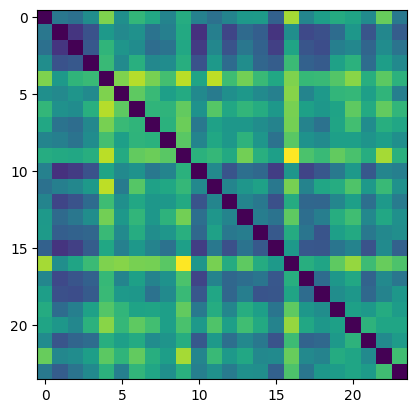

In [ ]:
plt.imshow(dist, cmap='viridis')

In [ ]:
import numpy as np                                                                                                                                                                                                                                                                                                          
from sklearn.decomposition import PCA                                 
from scipy.spatial import procrustes                                                                                                                                                                                                                                                                                        
from itertools import product                                                            
import matplotlib                                                                                                                                                                                                                                                                                                           
matplotlib.use('Agg')                                                                                                                                                                                                                                                                                                       
import matplotlib.pyplot as plt

data = np.load('tuning_curves.npz', allow_pickle=True)
tuning_all   = data['tuning_all']
id_col       = data['id_col']
age_group    = data['age_group']
monkey_names = list(data['monkey_names'])
age_edges    = data['age_edges']

# ── Tuning: cue + delay ──────────────────────────────────────────────────────
cue_rate   = tuning_all[:, :, 0]
delay_rate = np.nanmean(tuning_all[:, :, 1:3], axis=2)
tuning_cd  = np.stack([cue_rate, delay_rate], axis=2)

# ── PCA per (monkey, age) → 15 PCs ───────────────────────────────────────────
N_PCS = 15
monkey_ids, age_ids, matrices = [], [], []

for g in range(3):
    for mi, mid in enumerate(monkey_names):
        mask = (id_col == mid) & (age_group == g)
        X = tuning_cd[mask].reshape(-1, 16)
        good = np.all(np.isfinite(X), axis=1) & (np.std(X, axis=1) > 0)
        X = X[good]
        X = (X - X.mean(axis=1)[:, None]) #/ X.std(axis=1)[:, None]
        n_pcs = min(N_PCS, X.shape[0], 16)
        pca = PCA(n_components=n_pcs)
        X_pca = pca.fit_transform(X.T).T
        if n_pcs < N_PCS:
            X_pca = np.vstack([X_pca, np.zeros((N_PCS - n_pcs, 16))])
        matrices.append(X_pca)
        monkey_ids.append(mid)
        age_ids.append(g)

# ── Procrustes distance matrix ────────────────────────────────────────────────
n = len(matrices)
dist = np.zeros((n, n))
for i, j in product(range(n), repeat=2):
    if i < j:
        _, _, d = procrustes(matrices[i].T, matrices[j].T)
        dist[i, j] = dist[j, i] = d

# ── MDS-like embedding via PCA on distance matrix ────────────────────────────
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(dist)

# ── Plot ──────────────────────────────────────────────────────────────────────
colors = {m: c for m, c in zip(monkey_names,
        ['#e6194b', '#3cb44b', '#4363d8', '#f58231',
            '#911eb4', '#42d4f4', '#f032e6', '#bfef45'])}

fig, ax = plt.subplots(figsize=(9, 7))

for i in range(n):
    ax.scatter(coords[i, 0], coords[i, 1], s=500,
                c=colors[monkey_ids[i]], edgecolors='k', linewidths=0.8, zorder=3)
    ax.text(coords[i, 0], coords[i, 1], str(age_ids[i]),
            ha='center', va='center', fontsize=10, fontweight='bold',
            color='white', zorder=4)

# Legend for monkey colors
for mid in monkey_names:
    ax.scatter([], [], c=colors[mid], s=100, edgecolors='k', label=mid)
ax.legend(title='Monkey', loc='best', fontsize=9)

ax.set_xlabel('MDS dim 1')
ax.set_ylabel('MDS dim 2')
ax.set_title('Procrustes distances: MDS embedding\n(label = age group 0/1/2)')
plt.tight_layout()
plt.savefig('procrustes_mds.png', dpi=150)
print('Saved procrustes_mds.png')


Saved procrustes_mds.png
